<a href="https://colab.research.google.com/github/aSafarpoor/Seminar/blob/main/NGCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from matplotlib import pyplot as plt

In [3]:
%cd drive/MyDrive/MSc/codes/NGCF
!ls

/content/drive/MyDrive/MSc/codes/NGCF
dataPreprosessing.py  GCFmodel.py  __init__.py	run.py
DGLtest.py	      GraphNCF	   __pycache__	toyDataset


#DataPreprocessing

In [4]:
from torch.utils.data import Dataset

# movielens 1k

class ML1K(Dataset):

    def __init__(self,rt):
        super(Dataset,self).__init__()
        self.uId = list(rt['userId'])
        self.iId = list(rt['itemId'])
        self.rt = list(rt['rating'])

    def __len__(self):
        return len(self.uId)

    def __getitem__(self, item):
        return (self.uId[item],self.iId[item],self.rt[item])

#load data

In [5]:
!pwd
!ls

/content/drive/MyDrive/MSc/codes/NGCF
dataPreprosessing.py  GCFmodel.py  __init__.py	run.py
DGLtest.py	      GraphNCF	   __pycache__	toyDataset


In [6]:
import pandas as pd
from os import path

# load 100k data

# path100k = path.dirname(__file__) + r'\1K'
path100k = 'toyDataset/1K/ml-100k'
def load100KRatings():
    df = pd.read_table(path100k+'/u.data',sep='\t',names=['userId','itemId','rating','timestamp'])
    return df

def load100KItemSide():
    import codecs
    with codecs.open(path100k+'/u.item', 'r', 'utf-8', errors='ignore') as f:
        movies = pd.read_table(f, delimiter='|', header=None,names="itemId| movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children's | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western ".split('|'))
    return movies

def load100kUserSide():
    import codecs
    with codecs.open(path100k + '/u.user', 'r', 'utf-8', errors='ignore') as f:
        users = pd.read_table(f, delimiter='|', header=None,names="userId| age | gender | occupation | zip code".split('|'))
    return users

GCFmodel

In [7]:
import torch
import torch.nn as nn
from torch.nn import Module
from scipy.sparse import coo_matrix
from scipy.sparse import vstack
from scipy import sparse
import numpy as np


# several models for recommendations

# RMSE
# SVD dim = 50 50 epoch RMSE = 0.931
# GNCF dim = 64 layer = [64,64,64] nn = [128,64,32,] 50 epoch RMSE = 0.916/RMSE =0.914
# NCF dim = 64 50 nn = [128,54,32] epoch 50 RMSE = 0.928

class SVD(Module):

    def __init__(self,userNum,itemNum,dim):
        super(SVD, self).__init__()
        self.uEmbd = nn.Embedding(userNum,dim)
        self.iEmbd = nn.Embedding(itemNum,dim)
        self.uBias = nn.Embedding(userNum,1)
        self.iBias = nn.Embedding(itemNum,1)
        self.overAllBias = nn.Parameter(torch.Tensor([0]))

    def forward(self, userIdx,itemIdx):
        uembd = self.uEmbd(userIdx)
        iembd = self.iEmbd(itemIdx)
        ubias = self.uBias(userIdx)
        ibias = self.iBias(itemIdx)

        biases = ubias + ibias + self.overAllBias
        prediction = torch.sum(torch.mul(uembd,iembd),dim=1) + biases.flatten()

        return prediction

In [8]:
class NCF(Module):

    def __init__(self,userNum,itemNum,dim,layers=[128,64,32,8]):
        super(NCF, self).__init__()
        self.uEmbd = nn.Embedding(userNum,dim)
        self.iEmbd = nn.Embedding(itemNum,dim)
        self.fc_layers = torch.nn.ModuleList()
        self.finalLayer = torch.nn.Linear(layers[-1],1)

        for From,To in zip(layers[:-1],layers[1:]):
            self.fc_layers.append(nn.Linear(From,To))

    def forward(self, userIdx,itemIdx):
        uembd = self.uEmbd(userIdx)
        iembd = self.iEmbd(itemIdx)
        embd = torch.cat([uembd, iembd], dim=1)
        x = embd
        for l in self.fc_layers:
            x = l(x)
            x = nn.ReLU()(x)

        prediction = self.finalLayer(x)
        return prediction.flatten()


In [9]:
class GNNLayer(Module):

    def __init__(self,inF,outF):

        super(GNNLayer,self).__init__()
        self.inF = inF
        self.outF = outF
        self.linear = torch.nn.Linear(in_features=inF,out_features=outF)
        self.interActTransform = torch.nn.Linear(in_features=inF,out_features=outF)

    def forward(self, laplacianMat,selfLoop,features):
        # for GCF ajdMat is a (N+M) by (N+M) mat
        # laplacianMat L = D^-1(A)D^-1 # 拉普拉斯矩阵
        L1 = laplacianMat + selfLoop
        L2 = laplacianMat.cuda()
        L1 = L1.cuda()
        inter_feature = torch.sparse.mm(L2,features)
        inter_feature = torch.mul(inter_feature,features)

        inter_part1 = self.linear(torch.sparse.mm(L1,features))
        inter_part2 = self.interActTransform(torch.sparse.mm(L2,inter_feature))

        return inter_part1+inter_part2




In [10]:
class GCF(Module):

    def __init__(self,userNum,itemNum,rt,embedSize=100,layers=[100,80,50],useCuda=True):

        super(GCF,self).__init__()
        self.useCuda = useCuda
        self.userNum = userNum
        self.itemNum = itemNum
        self.uEmbd = nn.Embedding(userNum,embedSize)
        self.iEmbd = nn.Embedding(itemNum,embedSize)
        self.GNNlayers = torch.nn.ModuleList()
        self.LaplacianMat = self.buildLaplacianMat(rt) # sparse format
        self.leakyRelu = nn.LeakyReLU()
        self.selfLoop = self.getSparseEye(self.userNum+self.itemNum)

        self.transForm1 = nn.Linear(in_features=layers[-1]*(len(layers))*2,out_features=64)
        self.transForm2 = nn.Linear(in_features=64,out_features=32)
        self.transForm3 = nn.Linear(in_features=32,out_features=1)

        for From,To in zip(layers[:-1],layers[1:]):
            self.GNNlayers.append(GNNLayer(From,To))

    def getSparseEye(self,num):
        i = torch.LongTensor([[k for k in range(0,num)],[j for j in range(0,num)]])
        val = torch.FloatTensor([1]*num)
        return torch.sparse.FloatTensor(i,val)

    def buildLaplacianMat(self,rt):

        rt_item = rt['itemId'] + self.userNum
        uiMat = coo_matrix((rt['rating'], (rt['userId'], rt['itemId'])))

        uiMat_upperPart = coo_matrix((rt['rating'], (rt['userId'], rt_item)))
        uiMat = uiMat.transpose()
        uiMat.resize((self.itemNum, self.userNum + self.itemNum))

        A = sparse.vstack([uiMat_upperPart,uiMat])
        selfLoop = sparse.eye(self.userNum+self.itemNum)
        sumArr = (A>0).sum(axis=1)
        diag = list(np.array(sumArr.flatten())[0])
        diag = np.power(diag,-0.5)
        D = sparse.diags(diag)
        L = D * A * D
        L = sparse.coo_matrix(L)
        row = L.row
        col = L.col
        i = torch.LongTensor([row,col])
        data = torch.FloatTensor(L.data)
        SparseL = torch.sparse.FloatTensor(i,data)
        return SparseL

    def getFeatureMat(self):
        uidx = torch.LongTensor([i for i in range(self.userNum)])
        iidx = torch.LongTensor([i for i in range(self.itemNum)])
        if self.useCuda == True:
            uidx = uidx.cuda()
            iidx = iidx.cuda()

        userEmbd = self.uEmbd(uidx)
        itemEmbd = self.iEmbd(iidx)
        features = torch.cat([userEmbd,itemEmbd],dim=0)
        return features

    def forward(self,userIdx,itemIdx):

        itemIdx = itemIdx + self.userNum
        userIdx = list(userIdx.cpu().data)
        itemIdx = list(itemIdx.cpu().data)
        # gcf data propagation
        features = self.getFeatureMat()
        finalEmbd = features.clone()
        for gnn in self.GNNlayers:
            features = gnn(self.LaplacianMat,self.selfLoop,features)
            features = nn.ReLU()(features)
            finalEmbd = torch.cat([finalEmbd,features.clone()],dim=1)

        userEmbd = finalEmbd[userIdx]
        itemEmbd = finalEmbd[itemIdx]
        embd = torch.cat([userEmbd,itemEmbd],dim=1)

        embd = nn.ReLU()(self.transForm1(embd))
        embd = self.transForm2(embd)
        embd = self.transForm3(embd)
        prediction = embd.flatten()

        return prediction


In [11]:

if __name__ == '__main__':
    # from toyDataset.loaddata import load100KRatings

    rt = load100KRatings()
    userNum = rt['userId'].max()
    itemNum = rt['itemId'].max()

    rt['userId'] = rt['userId'] - 1
    rt['itemId'] = rt['itemId'] - 1
    gcf = GCF(userNum,itemNum,rt)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


# run

In [13]:
import torch
from torch import nn as nn
from scipy.sparse import coo_matrix
import pandas as pd
import numpy as np
from numpy import diag
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import Adam
from torch.nn import MSELoss
from tqdm import tqdm

rt = load100KRatings()
userNum = rt['userId'].max()
itemNum = rt['itemId'].max()

rt['userId'] = rt['userId'] - 1
rt['itemId'] = rt['itemId'] - 1
#
# rtIt = rt['itemId'] + userNum
# uiMat = coo_matrix((rt['rating'],(rt['userId'],rt['itemId'])))
# uiMat_upperPart = coo_matrix((rt['rating'],(rt['userId'],rtIt)))
# uiMat = uiMat.transpose()
# uiMat.resize((itemNum,userNum+itemNum))
# uiMat = uiMat.todense()
# uiMat_t = uiMat.transpose()
# zeros1 = np.zeros((userNum,userNum))
# zeros2 = np.zeros((itemNum,itemNum))
#
# p1 = np.concatenate([zeros1,uiMat],axis=1)
# p2 = np.concatenate([uiMat_t,zeros2],axis=1)
# mat = np.concatenate([p1,p2])
#
# count = (mat > 0)+0
# diagval = np.array(count.sum(axis=0))[0]
# diagval = np.power(diagval,(-1/2))
# D_ = diag(diagval)
#
# L = np.dot(np.dot(D_,mat),D_)
#
para = {
    'epoch':100,
    'lr':0.01,
    'batch_size':2048,
    'train':0.8
}

ds = ML1K(rt)
trainLen = int(para['train']*len(ds))
train,test = random_split(ds,[trainLen,len(ds)-trainLen])
dl = DataLoader(train,batch_size=para['batch_size'],shuffle=True,pin_memory=True)

model = GCF(userNum, itemNum, rt, 80, layers=[80,80,]).cuda()
# model = SVD(userNum,itemNum,50).cuda()
# model = NCF(userNum,itemNum,64,layers=[128,64,32,16,8]).cuda()
optim = Adam(model.parameters(), lr=para['lr'])
lossfn = MSELoss()

loss_list_reg = []
for i in tqdm(range(para['epoch'])):
    # print('epoch num: ',i+1)
    for id,batch in enumerate(dl):
        # print('epoch:',i,' batch:',id)
        optim.zero_grad()
        prediction = model(batch[0].cuda(), batch[1].cuda())
        loss = lossfn(batch[2].float().cuda(),prediction)

        l2_lambda = 0.01
        l2_reg = torch.tensor(0.).cuda()
        for param in model.parameters():
            l2_reg += torch.norm(param)
        loss += l2_lambda * l2_reg


        loss.backward()
        optim.step()
    try:
        for data in testdl:
            testdl = DataLoader(test,batch_size=len(test),)
            prediction = model(data[0].cuda(),data[1].cuda())
            loss = lossfn(data[2].float().cuda(),prediction)
            loss_list_reg.append(round(loss.item(),3))
    except Exception as e:
        print('some little error:',e)


testdl = DataLoader(test,batch_size=len(test),)
for data in testdl:
    prediction = model(data[0].cuda(),data[1].cuda())
    loss = lossfn(data[2].float().cuda(),prediction)


print(loss.item()) # MSEloss



100%|██████████| 100/100 [02:27<00:00,  1.48s/it]

0.8537408113479614


In [ ]:
# plt.plot(range(len(loss_list_wd)),loss_list_wd,label='weight decay')
# plt.plot(range(len(loss_list_no_reg)),loss_list_no_reg,label='without reguliozer')
# plt.plot(range(len(loss_list_reg)),loss_list_reg,label = 'with regulizer')
# plt.legend()

In [15]:
testdl = DataLoader(test,batch_size=len(test),)
for data in testdl:
    d = data.copy()
    break

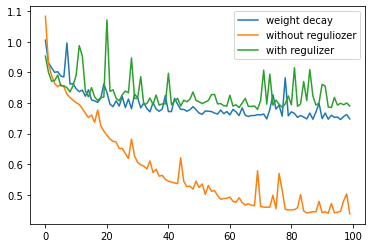